## import libraries

In [1]:
import os
import sys
from tqdm import tqdm
from time import time
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from sklearn import datasets
from sklearn.manifold import TSNE

cwd = os.getcwd()
module_path = "/".join(cwd.split('/')[0:-1])
if module_path not in sys.path:
    sys.path.append(module_path)

# Network architectures
from net.resnet2 import resnet50

from data_utils.ood_detection import cifar10,svhn
import metrics.uncertainty_confidence as uncertainty_confidence
from utils.gmm_utils import get_embeddings, gmm_fit, gmm_evaluate

## load model

In [2]:
device = "cuda:3" if torch.cuda.is_available() else "cpu"
# Load ResNet model
model = resnet50(spectral_normalization=True,
                             mod = True,
                             mnist = False).to(device)
model.load_state_dict(torch.load("../saved_models/run5/2024_03_26_17_00_27/resnet50_sn_3.0_mod_seed_1_best.model"))
activation = {}

def get_activation(name):
    def hook(model, input, output):
        activation[name] = input[0]
    return hook

model.fc.register_forward_hook(get_activation('embedding'))

In [11]:
num_classes = 10
batch_size = 512

# MNIST data loader
train_loader,val_loader = cifar10.get_train_valid_loader(batch_size,True,1,0,root="../data/")
ood_test_loader = svhn.get_test_loader(batch_size,root="../data/")
Xs = []
ys = []
for images,_ in tqdm(ood_test_loader):
    labels = np.ones(images.shape[0])*10 #标记label=10为OOD样本
    images = images.to(device)
    model(images)
    embeddings = activation["embedding"]
    Xs.append(embeddings.cpu().detach().numpy())
    ys.append(labels)
    
for images,labels in tqdm(train_loader):
    images = images.to(device)
    model(images)
    embeddings = activation["embedding"]
    Xs.append(embeddings.cpu().detach().numpy())
    ys.append(labels.detach().numpy())

Using downloaded and verified file: ../data/test_32x32.mat


100%|██████████| 98/98 [00:09<00:00, 10.30it/s]


In [12]:
X = np.concatenate(Xs)
y = np.concatenate(ys)

## t-SNE Visualization

In [85]:
def plot_embedding_3d(X, y,title=None):
    #坐标缩放到[0,1]区间
    x_min, x_max = np.min(X,axis=0), np.max(X,axis=0)
    X = (X - x_min) / (x_max - x_min)
    #降维后的坐标为（X[i, 0], X[i, 1],X[i,2]），在该位置画出对应的digits
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    for i in range(X.shape[0]):
        ax.text(X[i, 0], X[i, 1], X[i,2],str(y[i]),
                 color=plt.cm.Set1(y[i]),
                 fontdict={'weight': 'bold', 'size': 19})
    plt.xticks([])
    plt.yticks([])
    plt.title(title)
    return fig

def plot_embedding_2d(X, y, num_classes, title):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    fig = plt.figure()
    plt.scatter(X[:,0], X[:,1], c = y, s = 5, cmap = plt.cm.Spectral)


#     for i in range(num_classes): # 对每类的数据画上特定颜色的点
#         index = (y==i)
#         plt.scatter(X[index, 0], X[index, 1],s=3, c=colors[i])
    plt.legend([i for i in range(num_classes)])
    return fig

In [60]:
# tsne = TSNE(n_components=3, init='pca', random_state=0)
# X_tsne = tsne.fit_transform(X)
# plot_embedding_3d(X_tsne,y, "t-SNE 3D" )

In [43]:
tsne = TSNE(n_components=2, init='pca', random_state=0)
X_tsne = tsne.fit_transform(X)

KeyboardInterrupt: 

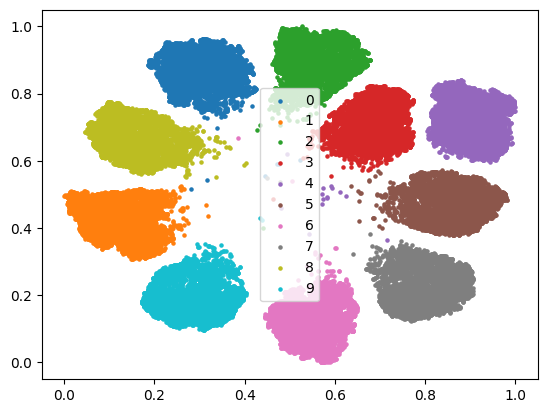

In [33]:
_ = plot_embedding_2d(X_tsne,y,10,"t-SNE 2D")

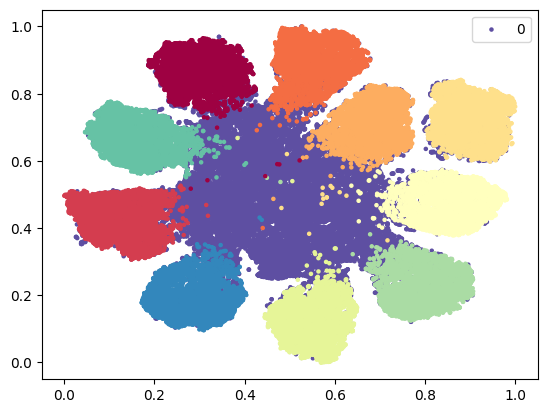

In [86]:
_ = plot_embedding_2d(X_tsne,y,11,"t-SNE 2D")

In [55]:

print(colors)

[[0.61960784 0.00392157 0.25882353 1.        ]
 [0.62806613 0.01330258 0.26082276 1.        ]
 [0.63652441 0.02268358 0.26282199 1.        ]
 [0.6449827  0.03206459 0.26482122 1.        ]
 [0.65344098 0.0414456  0.26682045 1.        ]
 [0.66189927 0.05082661 0.26881968 1.        ]
 [0.67035755 0.06020761 0.27081892 1.        ]
 [0.67881584 0.06958862 0.27281815 1.        ]
 [0.68727413 0.07896963 0.27481738 1.        ]
 [0.69573241 0.08835063 0.27681661 1.        ]
 [0.7041907  0.09773164 0.27881584 1.        ]]
